# Test 3

Instructions:
- Exercises are grouped by topic and ordered by increasing difficulty within each topic.
- Submit your solutions in a well-organized Jupyter notebook.
- You are responsible for creating robust test cases for each question. Ensure your tests cover all possible cases, especially edge cases (e.g., with the largest possible N ).
- Verify that all your solutions meet the specified time constraints. Unless otherwise stated, each question has a 1-second time limit. Some of the later questions may have different limits, which will be indicated.
- Be sure that the inputs (which will be created by you) match the specifications, and your solutions meets the required time limit.
- Presentation matters: make sure your notebook is clean, well-structured, and that both solutions and test cases are clearly labeled.

### Observations:
- For convenience and to get a better notebook some functions also returns the circuit implemented. This is because I would like to plot it. 

### Qiskit Imports

In [75]:
# from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import (
    HGate, 
    ZGate, 
    XGate, 
    YGate,
    IGate,
)
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler

import numpy as np
from numpy.random import default_rng, shuffle

rng = default_rng()

## Distinguishing Unitaries and States

### Exercise 1

**Exercise 1.** You are given an operation that implements a single-qubit unitary transformation: either the H gate or the X gate. The operation will have Adjoint and Controlled variants defined. Your task is to perform necessary operations and measurements to figure out which unitary it was and to return 0 if it was the H gate or 1 if it was the X gate. You are allowed to apply the given operation and its adjoint/controlled variants at most twice. You have to implement an operation which takes a single-qubit operation as an input and returns an integer.

#### Code

In [76]:
# 0 -> Gate H, 1 -> Gate X 
def solve1(operator) -> tuple[QuantumCircuit, int]:
    # We'll apply UXU|0> and measure.
    # When U=X -> XXX|0> = X|0> = |1>
    # When U=H -> HXH|0> = HX(|0>+|1>) = H(|0>+|1>) = |0>
    
    qc = QuantumCircuit(1, 1)           # 1 quibit + 1 bit (output measure)
    qc.append(operator, [0])
    qc.x(0)
    qc.append(operator, [0])
    
    qc.measure(0, 0)
    
    sampler = StatevectorSampler()
    job = sampler.run([qc], shots=1)
    result = job.result()[0].data['c'].get_counts() # A map with the measured val

    return qc, int([k for k in result.keys()][0])

#### Circuit Plot

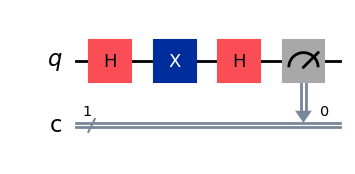

In [77]:
qch, _ = solve1(HGate())
qcx, _ = solve1(XGate())

qch.draw('mpl')

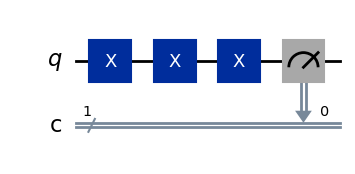

In [78]:
qcx.draw('mpl')

#### Test Code

In [79]:
# Testing 
tests = [i%2 for i in range(20)]
shuffle(tests)
result_test = {'Accepted':0, 'Wrong Answer':0}
tests_inputs = {'X':0, 'H':0}
for tt in tests:
    gate = XGate() if tt == 1 else HGate()
    tests_inputs[('X' if tt == 1 else 'H')] += 1
    expected = tt
    _, res = solve1(gate)
    if res == expected: 
        result_test['Accepted'] += 1
    else: 
        result_test['Wrong Answer'] += 1
    
### Showing results
print("The case tests:", tests_inputs)
print(result_test)

The case tests: {'X': 10, 'H': 10}
{'Accepted': 20, 'Wrong Answer': 0}


### Exercise 2

**Exercise 2.** You are given an operation that implements a single-qubit unitary transformation: either the identity (I gate) or one of the Pauli gates (X, Y or Z gate). The operation will have Adjoint and Controlled variants defined. Your task is to perform necessary operations and measurements to figure out which unitary it was and to return

- 0 if it was the I gate,
- 1 if it was the X gate,
- 2 if it was the Y gate,
- 3 if it was the Z gate.

You are allowed to apply the given operation and its adjoint/controlled variants exactly once. You have to implement an operation which takes a single-qubit operation as an input and returns an integer.

#### Code

In [80]:
# 0 -> Gate I, 1 -> Gate X, 2 -> Gate Y, 3 -> Gate Z 
def solve2(U_gate) -> tuple[QuantumCircuit, int]:
    # In: 1-qubit Operator 
    # We'll use the Bell States, from the |\Phi_+> we'll apply the Gate U
    # And we know where the States will be, in some Bell state so get them back by a measurement
    
    # Preparing |\Phi_+>
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(control_qubit=0, target_qubit=1)

    # Appy the U x I
    qc.append(U_gate, [0])

    # Measure in the Bell states -> Back into {|00>, |01>, |10>, |11>}
    # 00 -> I, 10 -> X, 01 -> Z, 11 -> Y
    qc.cx(control_qubit=0, target_qubit=1)
    qc.h(0)

    qc.measure([0,1],[0,1])

    sampler = StatevectorSampler()
    job = sampler.run([qc], shots=1)
    result = job.result()[0].data['c'].get_counts() # A map with the measured val
    
    result = [el for el in result.keys()][0]
    mp = {'00': 0, '10' : 1, '01' : 3, '11' : 2}
    return qc, mp[result]


#### Circuit Plot

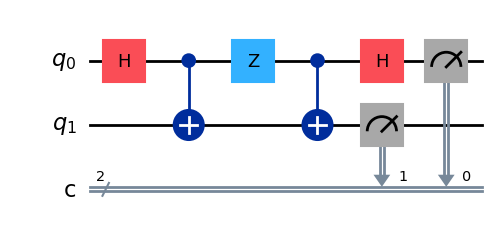

In [81]:
qc, _ = solve2(ZGate())
qc.draw('mpl')

#### Test Code

In [82]:
# Testing 
tests = [i%4 for i in range(200)]
shuffle(tests)
result_test = {'Accepted':0, 'Wrong Answer':0}
tests_inputs = {'I':0, 'X':0, 'Y':0, 'Z':0}
inmap = {0: 'I', 1:'X', 2:'Y', 3:'Z'}
gatemap = {0: IGate(), 1:XGate(), 2:YGate(), 3:ZGate()}

for tt in tests:
    gate = gatemap[tt]
    tests_inputs[inmap[tt]] += 1
    expected = tt
    
    res = solve2(gate)
    if res == expected: 
        result_test['Accepted'] += 1
    else: 
        result_test['Wrong Answer'] += 1
    
### Showing results
print("The case tests:", tests_inputs)
print(result_test)

The case tests: {'I': 50, 'X': 50, 'Y': 50, 'Z': 50}
{'Accepted': 0, 'Wrong Answer': 200}


### Exercise 3

**Exercise 3.** You are given 3 qubits which are guaranteed to be in one of the two states:
|ψ0⟩ = 1
√3(|100⟩ + ω|010⟩ + ω2|001⟩)
|ψ1⟩ = 1
√3(|100⟩ + ω2|010⟩ + ω|001⟩)
where ω = e2iπ/3.
Your task is to perform necessary operations and measurements to figure out which state
it was and to return 0 if it was |psi0⟩ state or 1 if it was |ψ1⟩ state. The state of the qubits
after the operations does not matter.
You have to implement an operation which takes an array of 3 qubits as an input and
returns an integer.

**Not Answered**

## Preparing States

### Exercise 4

**Exercise 4.** You are given two qubits in state |00⟩. Your task is to create the following
state on them: (|00⟩ + |01⟩ + |10⟩)/√3.
You have to implement an operation which takes an array of 2 qubits as an input and
has no output. The ”output” of your solution is the state in which it left the input qubits.

#### Code

In [83]:
from math import acos, sqrt

def solve4():
    # As done in Assignment 3, question 3.
    # R_y(k) = cos(k/2)|0> + sin(k/2)|1> 
    # with k = 2 arccos(1/\sqrt(3)), R_y |0> = \sqrt(1/3)|0> + \sqrt(2/3)|1> 
    # 1- So, R_y(k)|00> =  \sqrt(1/3)|00> + \sqrt(2/3)|10>
    # 2- Apply ctr-H (0 -> 1) => \sqrt(1/3)|00> + \sqrt(2/3)[\sqrt(1/2)(|10>+|11>)] = \sqrt(1/3)[|00> + |10> + |11>]
    # 3- Finally apply ctr-X (1 -> 0) => \sqrt(1/3)[|00> + |10> + |01>]
    
    angle = 2 * acos(1/sqrt(3))
    
    qc = QuantumCircuit(2,0)
    
    # 1.
    qc.ry(angle, [0])
    
    # 2. 
    qc.ch(control_qubit=0,target_qubit=1)
    
    # 3. 
    qc.cx(control_qubit=1, target_qubit=0)
    
    
    state = Statevector(qc)
    return qc, state


#### Circuit Plot

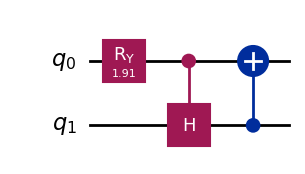

In [84]:
qc, _ = solve4()
qc.draw('mpl')    

#### Test Code

In [85]:
# Testing
_, state = solve4()
expected = Statevector([1/sqrt(3),1/sqrt(3),1/sqrt(3), 0])

result_test = {'Accepted':0, 'Wrong Answer':0}
result_test['Accepted' if state.equiv(expected) else 'Wrong Answer'] += 1
print(result_test)

{'Accepted': 1, 'Wrong Answer': 0}


### Exercise 5

**Exercise 5.** You are given N qubits in the state |0 · · · 0⟩, and an integer parity ∈ {0, 1}.
Your task is to prepare an equal superposition of all basis states that have the given parity
of the number of 1s in their binary notation, i.e., the basis states that have an even number
of 1s if parity=0 or the basis states that have an odd number of 1s if parity=1.
For example, for N = 2 the required state would be (|00⟩ + |11⟩)/√2 if parity=0, and
(|01⟩ + |10⟩)/√2 if parity=1.
You are not allowed to use any gates except the Pauli gates (X, Y and Z), the Hadamard
gate and the controlled versions of those (you are allowed to use multiple qubits as controls
in the controlled versions of gates). However, you are allowed to use measurements.
You have to implement an operation which takes an array of N qubits and an integer as
an input and has no output. The ”output” of your solution is the state in which it left the
input qubits.

#### Code

In [86]:
def solve5(initial_state : Statevector, N: int, parity : int) -> None:

    qc = QuantumCircuit(N)
    qc.initialize(initial_state)
    for i in range(1, N):
        qc.h(i)
        
    for i in range(1, N):
        qc.cx(control_qubit=i, target_qubit=0)
        
    # In the final we have the string with even number of ones, because 
    # - we invert the 0-qubit even times if the [1, n-1] have even one bits, the 0-qubit goes to 0 so the bit string have even ones.
    # - we invert the 0-qubit odd times if the [1, n-1] have odd one bits, the 0-qubit goes to 1 so the bit string have even ones.
    
    if parity == 1:
        qc.x(0)
    
    state = Statevector(qc)
    return qc, state


#### Circuit Plot

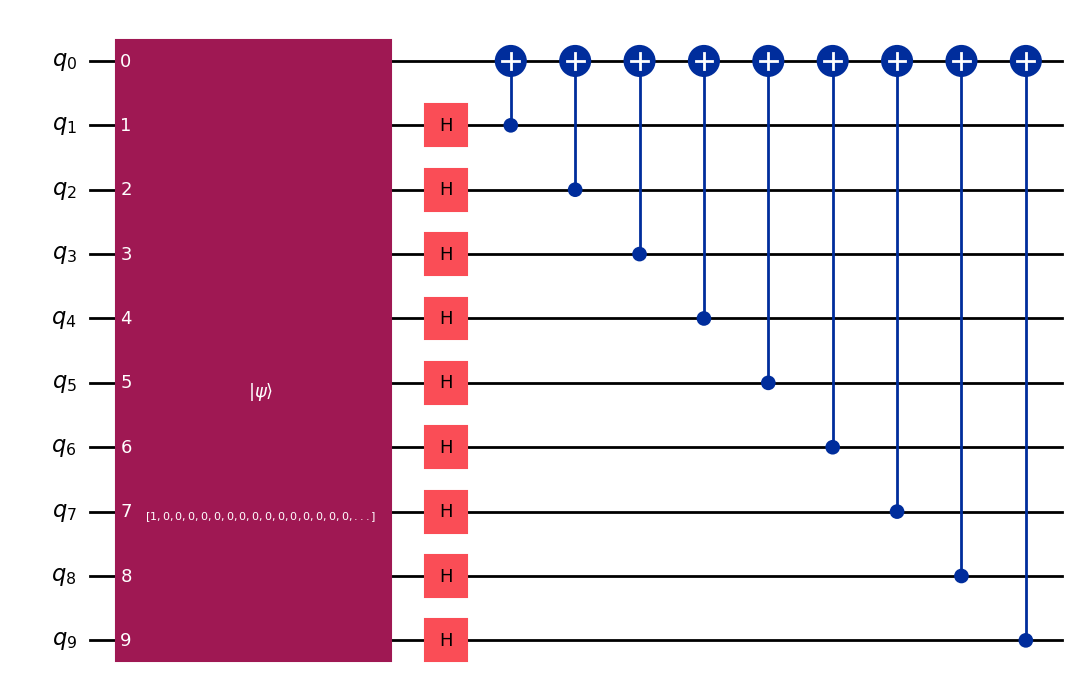

In [87]:
qc, _ = solve5(Statevector.from_label('0'*10), 10, 0)
qc.draw('mpl')

#### Test Code

In [88]:
# Testing
N = 10
strs = [[] for _ in range(2)]
for i in range(2**N):
    cnt = bin(i).count('1')
    strs[cnt%2].append(i)
    
for i in range(2): # parity
    print('parity', i)
    _, state = solve5(Statevector.from_label('0'*N), N, i)
    state = state.data 
    strs_expected = strs[i]
    expected_c = 1/sqrt(len(strs_expected))
    
    print('\tTesting the number of amplitutes equal to expected')
    diff_zero_states = [el for el in state if el != 0]
    if len(strs_expected) == len(diff_zero_states):
        print('\t\tAccepted')
    else :
        print('\t\tWrong Answer')
    # print('Expected:', len(strs_expected), 'Got: ', len(diff_zero_states))

    print('\tTesting the setted indices are the expected')
    cnt = 0
    for i in strs_expected:
        if np.isclose(state[i], expected_c):
            cnt += 1 
        else: print(state[i], expected_c)
    
    if cnt == len(strs_expected):
        print('\t\tAccepted')
    else:
        print('\t\tWrong Answer')

parity 0
	Testing the number of amplitutes equal to expected
		Accepted
	Testing the setted indices are the expected
		Accepted
parity 1
	Testing the number of amplitutes equal to expected
		Accepted
	Testing the setted indices are the expected
		Accepted


### Exercise 6

**Exercise 6.** You are given two qubits which are guaranteed to be in one of the Bell states:
|Φ+⟩ = 1
√2 (|00⟩ + |11⟩)
|Φ−⟩ = 1
√2 (|00⟩ − |11⟩)
|Ψ+⟩ = 1
√2 (|01⟩ + |10⟩)
|Ψ−⟩ = 1
√2 (|01⟩ − |10⟩)
2
Your task is to perform necessary operations and measurements to figure out which state it
was and to return the index of that state (0 for Φ+, 3 for Ψ−, etc.). The state of the qubits
after the operations does not matter.
You have to implement an operation which takes an array of two qubits as an input and
returns an integer.

#### Code

In [89]:
def solve6(initial_state : Statevector) -> int:
    # It's like what's done in exercise 2
    qc = QuantumCircuit(2, 2)
    qc.initialize(initial_state)
    
    # Moving to {|00>, |01>, |10>, |11>} basis in measurement
    qc.cx(0, 1)
    qc.h(0)
    
    qc.measure([0,1],[0,1])

    sampler = StatevectorSampler()
    job = sampler.run([qc], shots=1)
    result = job.result()[0].data['c'].get_counts() # A map with the measured val
    result = [el for el in result.keys()][0]
    mp = {'00': 0, '01' : 1, '10' : 2,  '11' : 3}
    return qc, mp[result]


def get_bell_state(name: str):
    # Preparing |\Phi_+> 
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(control_qubit=0, target_qubit=1)
    
    if name == 'Phi-': 
        qc.z(0)
    elif name == 'Psi+':
        qc.x(0)
    elif name == 'Psi-':
        qc.y(0)
    
    return Statevector(qc)
    

#### Circuit Plot

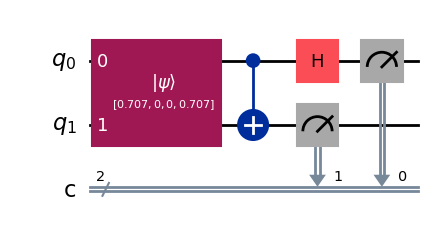

In [90]:
qc, _ = solve6(get_bell_state('Phi+'))
qc.draw('mpl')

#### Test Code

In [91]:
# Testing
 
tests = [i%4 for i in range(200)]
shuffle(tests) # Shuffles the test array
result_test = {'Accepted':0, 'Wrong Answer':0}
tests_inputs = {'Phi+':0, 'Phi-':0, 'Psi+':0, 'Psi-':0}
inmap = {0: 'Phi+', 1:'Phi-', 2:'Psi+', 3:'Psi-'}
states = { i: get_bell_state(inmap[i]) for i in range(4) }

for tt in tests:
    state_to_test = states[tt]
    tests_inputs[inmap[tt]] += 1
    expected = tt
    
    _, res = solve6(state_to_test)
    if res == expected: 
        result_test['Accepted'] += 1
    else: 
        result_test['Wrong Answer'] += 1
        print('Expected', expected, 'Got', res)
    
### Showing results
print("The case tests:", tests_inputs)
print(result_test)

The case tests: {'Phi+': 50, 'Phi-': 50, 'Psi+': 50, 'Psi-': 50}
{'Accepted': 200, 'Wrong Answer': 0}


## Quantum Oracles

### Exercise 7

**Exercise 7.** Implement a quantum oracle on N qubits which checks whether the bits in the
input vector x alternate (i.e., implements the function f (x) = 1 if x does not have a pair of
equal adjacent bits).
You have to implement an operation which takes the following inputs: an array of N (1 ≤
N ≤ 7) qubits x in an arbitrary state (input register), a qubit y in an arbitrary state (output
qubit), and performs a transformation |x⟩|y⟩ → |x⟩|y ⊕ f (x)⟩.The operation doesn’t have an
output; its ”output” is the state in which it leaves the qubits. Note that the input register
x has to remain unchanged after applying the operation.
This question has a special time limit: 2 seconds.

#### Code

In [92]:
# Implementation of the oracle
def solve7(initial_state: Statevector, N: int):
    
    data = QuantumRegister(N, name='data')
    output = QuantumRegister(1, name='out')
    anc = QuantumRegister(N-1, name='anc')
    qc = QuantumCircuit(data, output, anc)
    
    qc.initialize(initial_state, data)
    
    if N == 1:
        qc.x(1)
        return qc
    
    # CNOTs on adjacent qubits with target on ancilla to know they are equal or not
    
    for i in range (0, N-1):
        qc.mcx(control_qubits=[data[i], data[i+1]], target_qubit=anc[i])       
        
    for i in range (0, N):
        qc.x(data[i])
    
    for i in range (0, N-1):
        qc.mcx(control_qubits=[data[i], data[i+1]], target_qubit=anc[i])       
        
    # Returning to initial state
    for i in range (0, N):
        qc.x(data[i])
    
    # Left we check the ancillas, for any 1 -> |0> on f(x), else -> |1>
    for i in range(0, N-1):
        qc.x(anc[i])
        
    if N > 1: 
        qc.mcx(control_qubits=anc, target_qubit=output[0])
    
    return qc


#### Circuit Plot

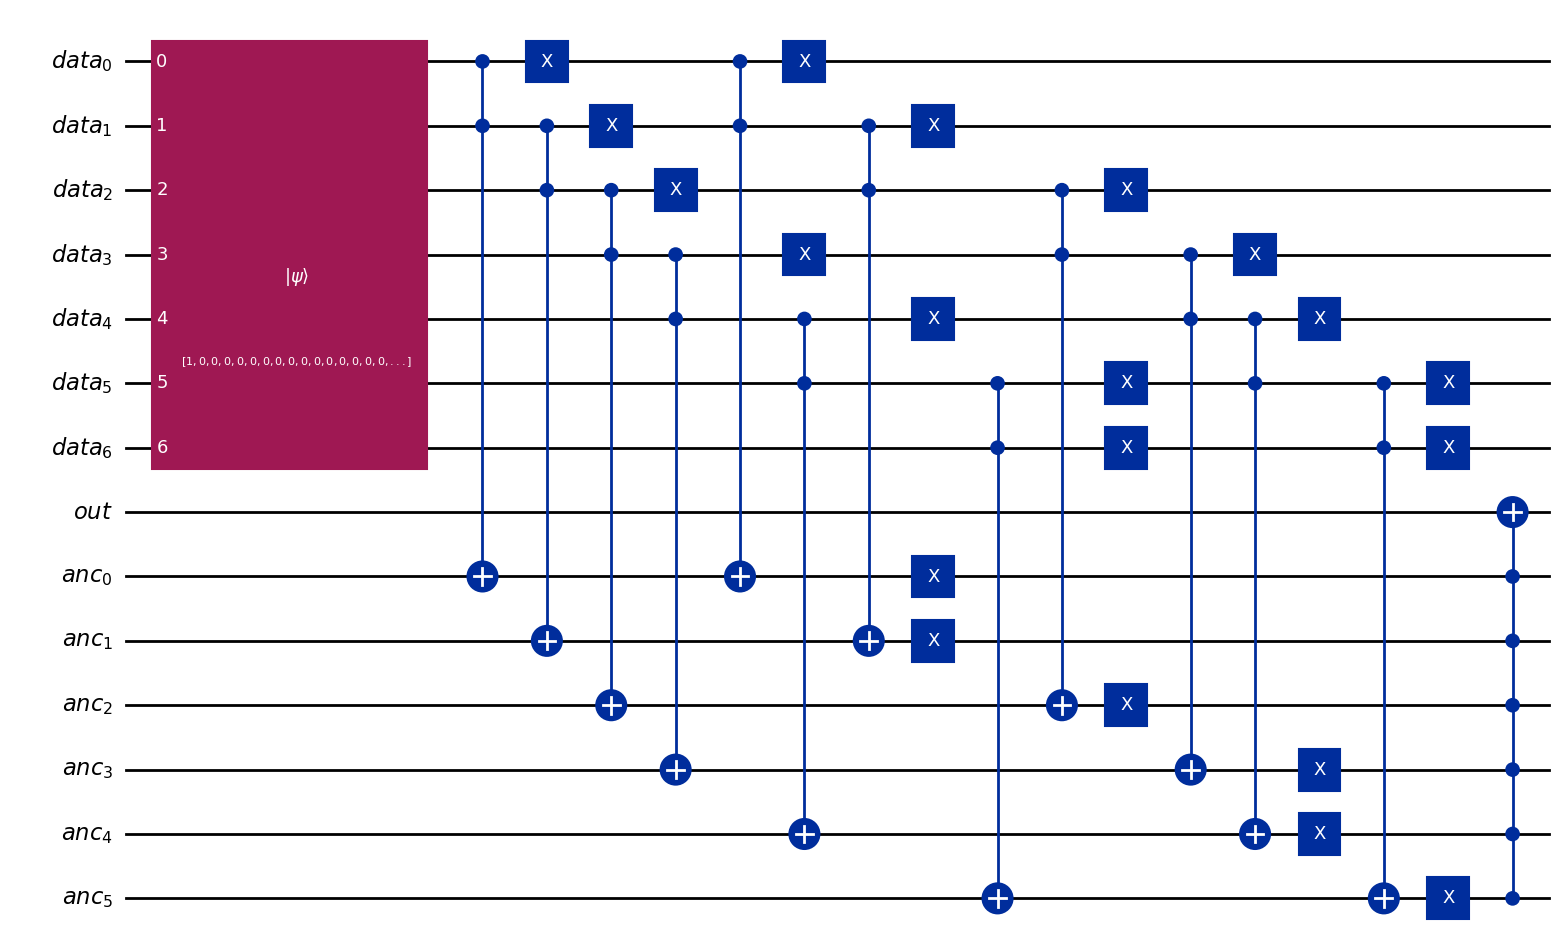

In [93]:
N = 7
oracle = solve7(Statevector.from_label('0000000'), N)
oracle.draw('mpl')

#### Test Code

In [94]:
# Testing

result_test = {'Accepted':0, 'Wrong Answer':0}

for n_qubits in range(1,7):
    all_bit_strs = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    s1 = ''.join('01'[i%2] for i in range(n_qubits))
    s2 = ''.join('10'[i%2] for i in range(n_qubits))

    alternates = [s1, s2]
    non_alternates = set([s for s in all_bit_strs if s not in alternates])

    shuffle(all_bit_strs)
    
    for bit_str in all_bit_strs:
        
        oracle = solve7(Statevector.from_label(bit_str), n_qubits) 
        total_qubits = oracle.num_qubits

        data = QuantumRegister(n_qubits, name='data')
        output = QuantumRegister(1, name='out')
        anc = QuantumRegister(n_qubits-1, name='anc')
        meas = ClassicalRegister(1, name='meas')

        qc = QuantumCircuit(data, output, anc, meas)
            
        qc.append(oracle.to_instruction(), range(total_qubits))
        qc.measure(output[0], meas)

        sampler = StatevectorSampler()
        job = sampler.run([qc], shots=1)
        result = job.result()[0].data['meas'].get_counts() # A map with the measured val
        
        result = int(list(result.keys())[0])
        expected = 1 if bit_str in alternates else 0
         
        if result == expected:
            result_test['Accepted'] += 1
        else:
            print(f'Test {bit_str}, Expected {expected}, Got {result}')
            result_test['Wrong Answer'] += 1
    
print('Number of test cases ', 2**7 - 2)
print(result_test)
    


Number of test cases  126
{'Accepted': 126, 'Wrong Answer': 0}


### Exercise 8

**Exercise 8.** Implement a quantum oracle on N qubits which checks whether the bits in the input vector x form a periodic bit string (i.e., implements the function f (x) = 1 if x is periodic, and 0 otherwise). A bit string of length N is considered periodic with period P (1 ≤ P ≤ N − 1) if for all i ∈ [0, N − P − 1] : xi = xi + P . Note that P does not have to divide N evenly; for example, bit string ”01010” is periodic with period P=2. You have to implement an operation which takes the following inputs: an array of N (1 <= N <= 7) qubits x in an arbitrary state (input register), a qubit y in an arbitrary state (output qubit), and performs a transformation |x⟩|y⟩ → |x⟩|y ⊕ f (x)⟩.The operation doesn’t have an output; its ”output” is the state in which it leaves the qubits. Note that the input register x has to remain unchanged after applying the operation.
This exercise has a special time limit: 4 seconds.

**Not Answered**

### Exercise 9

**Exercise 9.** Implement a quantum oracle on N qubits which checks whether the bits in the input vector x form a palindrome bit string (i.e., implements the function f (x) = 1 if x is palindrome, and 0 otherwise). You have to implement an operation which takes the following inputs: an array of N (1 <= N <= 8) qubits x in an arbitrary state (input register), a qubit y in an arbitrary state (output qubit), and performs a transformation |x⟩|y⟩ → |x⟩|y ⊕ f (x)⟩.The operation doesn’t have an output; its ”output” is the state in which it leaves the qubits. Note that the input register x has to remain unchanged after applying the operation.
This exercise has a special time limit: 2 seconds.

#### Code

In [95]:
# Implementation of the oracle
def solve9(initial_state: Statevector, N: int):
    
    data = QuantumRegister(N, name='data')
    output = QuantumRegister(1, name='out')
    qc = QuantumCircuit(data, output)
    
    qc.initialize(initial_state, data)
    
    if N == 1:
        qc.x(1)
        return qc
    
    for i in range(0, N//2):
        qc.cx(control_qubit=data[N-i-1], target_qubit=data[i])
        qc.x(i)
    
    qc.mcx(control_qubits=[data[i] for i in range(N//2)], target_qubit=output)
    
    # Returning to initial state
    for i in range(0, N//2):
        qc.x(i)
        qc.cx(control_qubit=data[N-i-1], target_qubit=data[i])
    
    return qc


#### Circuit Plot

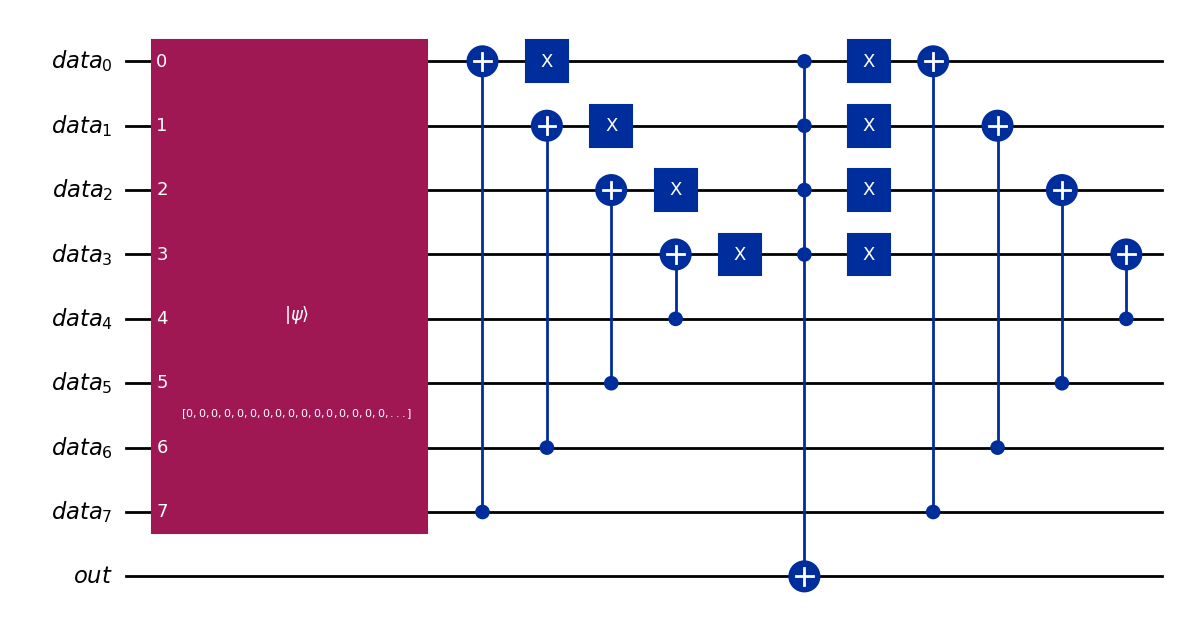

In [96]:
N = 8
oracle = solve9(Statevector.from_label('00101011'), N)
oracle.draw('mpl')

#### Test Code

In [97]:
# Testing
result_test = {'Accepted':0, 'Wrong Answer':0}

for n_qubits in range(1,8):
    all_bit_strs = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    
    valid_strs = set()
    for bit_str in [format(i, f'0{(n_qubits+1)//2}b') for i in range(2**((n_qubits+1)//2))]:
        left = ''.join(bit_str)
        if n_qubits % 2 == 0:
            right = left[::-1]
        else:
            right = left[:-1][::-1]
        valid_strs.add(left + right)
    
    shuffle(all_bit_strs)
    
    for bit_str in all_bit_strs:
        oracle = solve9(Statevector.from_label(bit_str), n_qubits) 
        total_qubits = oracle.num_qubits

        data = QuantumRegister(n_qubits, name='data')
        output = QuantumRegister(1, name='out')
        meas = ClassicalRegister(1, name='meas')

        qc = QuantumCircuit(data, output, meas)
            
        qc.append(oracle.to_instruction(), range(total_qubits))
        qc.measure(output[0], meas)

        sampler = StatevectorSampler()
        job = sampler.run([qc], shots=1)
        result = job.result()[0].data['meas'].get_counts() # A map with the measured val
        
        result = int(list(result.keys())[0])
        expected = 1 if bit_str in valid_strs else 0
         
        if result == expected:
            result_test['Accepted'] += 1
        else:
            print(f'Test {bit_str}, Expected {expected}, Got {result}')
            result_test['Wrong Answer'] += 1
    
print('Number of test cases ', result_test['Accepted'] + result_test['Wrong Answer'])
print(result_test)

Number of test cases  254
{'Accepted': 254, 'Wrong Answer': 0}


In [98]:
# You may test also separated tests
n_qubits = 9
oracle = solve9(Statevector.from_label('000010000'), n_qubits) 
total_qubits = oracle.num_qubits

data = QuantumRegister(n_qubits, name='data')
output = QuantumRegister(1, name='out')
meas = ClassicalRegister(1, name='meas')

qc = QuantumCircuit(data, output, meas)
    
qc.append(oracle.to_instruction(), range(total_qubits))
qc.measure(output[0], meas)

sampler = StatevectorSampler()
job = sampler.run([qc], shots=1)
result = job.result()[0].data['meas'].get_counts() # A map with the measured val

result = int(list(result.keys())[0])
print(f'Expected {1}, result {result}')

Expected 1, result 1
